pixelliste für einen nutzer holen

In [1]:
from src.data.dataset_functions import get_dataframe

dataFrame = get_dataframe(True) # sample data only
from src.features.feature_functions import group_dataframe_by_user
groupedFrame = group_dataframe_by_user(dataFrame)


providing ../data/raw/2022_place_canvas_history-000000000050.csv ...
../data/raw/2022_place_canvas_history-000000000050.csv is already in data/raw
:: loading settings :: url = jar:file:/usr/local/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/vscode/.ivy2/cache
The jars for the packages stored in: /home/vscode/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-64142ccc-f820-4f9b-80ef-07a01d5764a2;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
downloading https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar ...
	[SUCCESSFUL ] graphframes#graphframes;0.8.2-spark3.2-s_2.12!graphframes.jar (86ms)
downloading https://repo1.maven.org/maven2/org/slf4j/slf4j-api/1.7.16/slf4j-api-1.7.16.jar ...
	[SUCCESSFUL ] org.slf4j#slf4j-api;1.7.16!slf4j-api.jar (63ms)
:: resolution report :: resolve 5764ms :: artifacts dl 155ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	----------

In [2]:
headrow = groupedFrame.head(1)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from src.models.models import RZModel

headrow = headrow[0]
print(headrow)


Row(user_id='AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w==', count=20, collect_list(x)=[1617, 1447, 655, 1636, 612, 1287, 1575, 1926, 1310, 1611, 658, 584, 1403, 1765, 777, 1741, 1299, 586, 788, 656], collect_list(y)=[16, 5, 1896, 21, 1917, 8, 7, 19, 10, 33, 14, 26, 2, 8, 8, 10, 20, 1931, 11, 1884], collect_list(t)=[1417, 184, 1726, 492, 1726, 801, 1726, 801, 1109, 3269, 2035, 3577, 2344, 3577, 2344, 2344, 2653, 2653, 2961, 2961], collect_list(pixel_color)=['#FF4500', '#FFA800', '#B44AC0', '#FFFFFF', '#E4ABFF', '#3690EA', '#FFA800', '#BE0039', '#2450A4', '#2450A4', '#FF4500', '#000000', '#FFA800', '#FFA800', '#FFA800', '#FFA800', '#FFFFFF', '#9C6926', '#000000', '#E4ABFF'])


[[1617, 1447, 655, 1636, 612, 1287, 1575, 1926, 1310, 1611, 658, 584, 1403, 1765, 777, 1741, 1299, 586, 788, 656], [16, 5, 1896, 21, 1917, 8, 7, 19, 10, 33, 14, 26, 2, 8, 8, 10, 20, 1931, 11, 1884], [1417, 184, 1726, 492, 1726, 801, 1726, 801, 1109, 3269, 2035, 3577, 2344, 3577, 2344, 2344, 2653, 2653, 2961, 2961]]


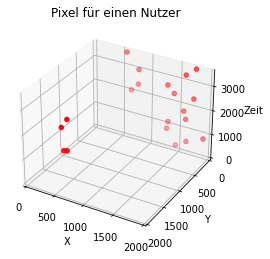

In [4]:
from src.visualization.visuialization_functions import plot_pixel_boundingbox,plot_pixellist,new_xyt_plot,show_and_save
pixelliste = [headrow['collect_list(x)'],headrow['collect_list(y)'],headrow['collect_list(t)']]
print(pixelliste)
subplot = new_xyt_plot()
subplot = plot_pixellist(pixellist=pixelliste,subplot = subplot, finish = False,color='red')
subplot.set_title('Pixel für einen Nutzer')
subplot.set_zlim([0,3601])
show_and_save(subplot)



[[1617, 1447, 655, 1636, 612, 1287, 1575, 1926, 1310, 1611, 658, 584, 1403, 1765, 777, 1741, 1299, 586, 788, 656], [16, 5, 1896, 21, 1917, 8, 7, 19, 10, 33, 14, 26, 2, 8, 8, 10, 20, 1931, 11, 1884], [1417, 184, 1726, 492, 1726, 801, 1726, 801, 1109, 3269, 2035, 3577, 2344, 3577, 2344, 2344, 2653, 2653, 2961, 2961]]


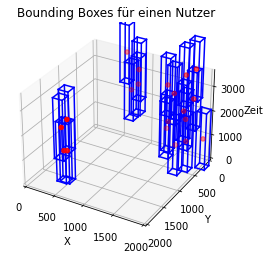

In [5]:
from src.visualization.visuialization_functions import *
import numpy as np
print(pixelliste)
RZModel.max_xy_dist = 80
RZModel.max_t_dist = 20*60
x_list = pixelliste[0]
y_list = pixelliste[1]
t_list = pixelliste[2]
subplot = new_xyt_plot()
subplot = plot_pixellist(pixelliste,subplot = subplot, finish = False,color='red')
for i in np.arange(0,len(x_list)):
    subplot = plot_pixel_boundingbox(x_list[i],y_list[i],t_list[i],color='blue',subplot=subplot,finish=False)

subplot.set_title('Bounding Boxes für einen Nutzer')
subplot.set_zlim([0,3601])
show_and_save(subplot)